In [1]:
from collections import defaultdict
import numpy as np
from itertools import combinations
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from matplotlib import pyplot as plt
import networkx as nx
import networkx.generators.community as community
import ndlib
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.utils import multi_runs
from bokeh.palettes import Category20_9 as cols
import future.utils
import warnings
from random import randint
warnings.simplefilter('ignore')
%matplotlib inline

no display found. Using non-interactive Agg backend


In [2]:
# Create QUBO dict for D-Wave to optimize
def maxcut_qubo(G):
    # The Hamiltonian is H = sum(Pauli_Z(i) x Pauli_Z(j) - I)/2
    # The eigenvalue is the negation of the edges in cut solution
    # The QUBO should be -xi-xj+2xixj, we label it as Q
    Q = defaultdict(int)
    for u, v in G.edges:
        Q[(u,u)]+= -1
        Q[(v,v)]+= -1
        Q[(u,v)]+= 2
    return Q

# Invoke D-Wave annealer
def solve(Q, chainstrength=8, numruns=100):
    # Run the QUBO on the solver from your config file
    sampler = EmbeddingComposite(DWaveSampler(solver={'qpu': True}))
    response = sampler.sample_qubo(Q, chain_strength=chainstrength, num_reads=numruns)
    energies = iter(response.data())
    return response.first

def brute_best(G):
    sub_lists = []
    for i in range(0, len(G.nodes())+1):
        temp = [list(x) for x in combinations(G.nodes(), i)]
        sub_lists.extend(temp)   
    # Calculate the cut_size for all possible cuts
    cut_size = []
    for sub_list in sub_lists:
        cut_size.append(nx.algorithms.cuts.cut_size(G,sub_list))
    return max(cut_size)

# Return a list of subgraphs representing a splitting of people into quarantine groups
def binary_split(G, limit = 4, pos=None, infected_nodes = [], graph=False, print_progress=False, weighted = False):
    #Recursively take maxcut on left and right subsets of graph if graph has more than limit people
    #sol: sample object returneb by solve(G)
    if pos == None:
        pos = nx.spring_layout(G)

    if len(G.nodes) <= limit or len(G.edges) == 0: #recursion base case and if no edges D-Wave will error
        return [G]
    else:
        if weighted == False:
            Q = maxcut_qubo(G)
        else:
            Q = weighted_maxcut_qubo(G)
        sol = solve(Q)
        
    labels = sol.sample
    for node in G.nodes: # D-Wave doesn't assign labels to isolated vertices so assign to 0
        if node not in labels:
            labels[node] = 0
    colors = ['g' if i in infected_nodes else ('r' if labels[i] == 0 else 'b') for i in G.nodes]
    left = [i for i in G.nodes if labels[i] == 0] # had to change to 0 from -1
    right = [i for i in G.nodes if labels[i] == 1]
    
    if graph:
        fig = plt.figure(constrained_layout=False)
        gs = fig.add_gridspec(nrows=2, ncols=3)
        gs.update(wspace=0, hspace=0)
        ax1 = fig.add_subplot(gs[:,:2])   
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax2 = fig.add_subplot(gs[0,2])  
        ax2.set_xticklabels([])
        ax2.set_yticklabels([])
        ax3 = fig.add_subplot(gs[1,2]) 
        ax3.set_xticklabels([])
        ax3.set_yticklabels([])
    
    left_G = G.subgraph(left)
    right_G = G.subgraph(right)
    left_colors = ['g' if i in infected_nodes else 'r'  for i in left_G.nodes]
    right_colors = ['g' if i in infected_nodes else 'b' for i in right_G.nodes]
    if print_progress == True:
        print("Dividing {} people into {} & {}".format(len(G.nodes), len(left_G.nodes), len(right_G.nodes)))
    
    if graph:
        nx.draw_networkx(G, node_size=300, alpha=.8, ax=ax1, pos=pos, node_color=colors)
        nx.draw_networkx(left_G, node_size=300, alpha=.8, ax=ax2, pos=pos, node_color=left_colors)
        nx.draw_networkx(right_G, node_size=300, alpha=.8, ax=ax3, pos=pos, node_color=right_colors)
    
    group = []
    group.extend(binary_split(left_G, pos=pos, infected_nodes=infected_nodes, limit=limit, graph=graph))    
    group.extend(binary_split(right_G, pos=pos, infected_nodes=infected_nodes, limit=limit, graph=graph))     
    
    return group

#plot graph with each isolated group in a different random color
def plot_colorized_groups(G, groups, infected):
    
    def n_random_colors(n):
        colors = []
        for i in range(n):
            colors.append('#%06X' % randint(0, 0xFFFFFF))
        return colors

    node_colors = [None for i in G.nodes]
    palette = n_random_colors(len(groups))
    for graph, color in zip(groups, palette):
        for node in graph.nodes:
            node_colors[node] = color
    for node in infected:
        node_colors[node] = 'red'

    pos = nx.spring_layout(G)
    fig = plt.figure(figsize=(6,6))
    default_axes = fig.add_subplot(frameon=True)
    nx.draw_networkx(G, node_size=400, alpha=1, node_color=node_colors)
    default_axes.set_title("You should not rave right now")
    plt.show()
    
#plot graph with each isolated group in a different spacial region
def plot_spacially_isolated_groups(G, groups, infected):
    # TODO, import grave package, use grave.plot_network as in 
    #https://networkx.github.io/grave/latest/gallery/plot_layout_custom.html
    return

In [3]:
#Epidemic Modelling

# simulate virus spread on entire graph, return stats
def sim_virus(G, r_infect=0.001, r_recover=0.01, infected_nodes = [], iteration=500):
    #iteration: number of steps of virus spread
    #returns: model, trends: dictionary indexed by number of susceptible (0), infected (1) and removed (2) nodes
    #iterations: dictionary indexed by iteration, containing the state of every node at that iteration
    #https://ndlib.readthedocs.io/en/latest/reference/models/epidemics/SIR.html
    model = ep.SIRModel(G)
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', r_infect) # infection rate
    cfg.add_model_parameter('gamma', r_recover) # recovery rate
    cfg.add_model_initial_configuration("Infected", infected_nodes)
    model.set_initial_status(cfg)
    iterations = model.iteration_bunch(iteration, node_status=False)
    trends = model.build_trends(iterations)     
    return model, trends, iterations 

# simulate virus spread in each quarantined group seperately, aggregate to whole population and return stats
def sim_virus_group(G, groups, original_model, r_infect=0.001, r_recover=0.01, original_infected_nodes = [], iteration=500):
    net_trends = {'trends': {'node_count': {0:[0]*iteration, 1:[0]*iteration, 2:[0]*iteration}}}
    for g in groups:
        model, trends, iterations = sim_virus(g, r_infect, r_recover, [n for n in original_infected_nodes if n in g.nodes], iteration)
        for idx,i in enumerate(iterations):
            i_count = i['node_count']
            for jk, jv in i_count.items():
                net_trends['trends']['node_count'][jk][idx] += jv
    #print(net_trends)
    for i in range(iteration):
        ctr = net_trends['trends']['node_count'][0][i]+net_trends['trends']['node_count'][1][i]+net_trends['trends']['node_count'][2][i]
        assert ctr == len(G.nodes), (ctr,i)
    return original_model, [net_trends]


## Test on 30 node complete graph

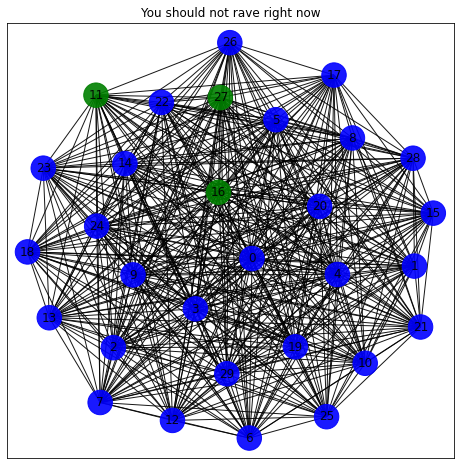

In [88]:
n = 30
G_init_infect = 0.1
G = nx.generators.classic.complete_graph(n)
pos = nx.spring_layout(G)
fig = plt.figure(figsize=(8,8))
default_axes = fig.add_subplot(frameon=True)
infected = np.random.choice(range(n), int(n*init_infect), replace=False)
colors = ['g' if i in infected else 'b' for i in G.nodes]
nx.draw_networkx(G, node_size=600, alpha=.9, node_color=colors)
default_axes.set_title("You should not rave right now")
plt.show()

# A toy example showing the split

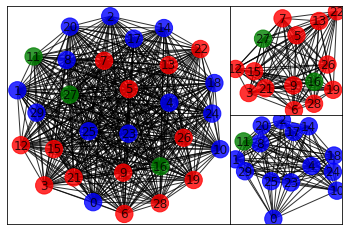

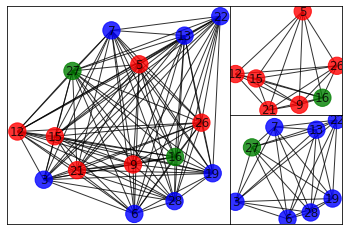

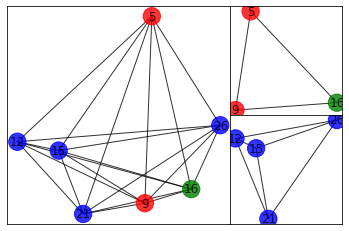

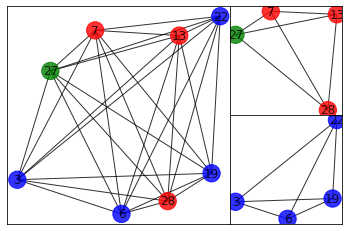

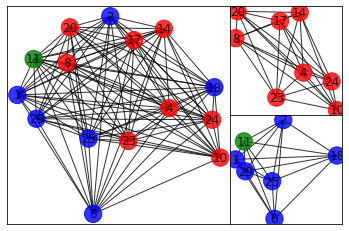

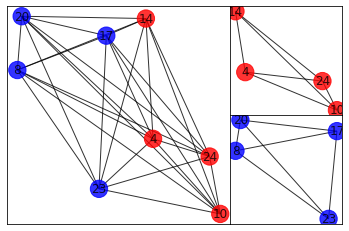

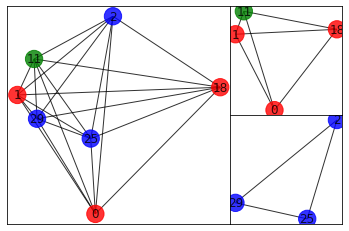

In [163]:
groups = binary_split(G, infected_nodes = infected, limit = 4, graph = True)

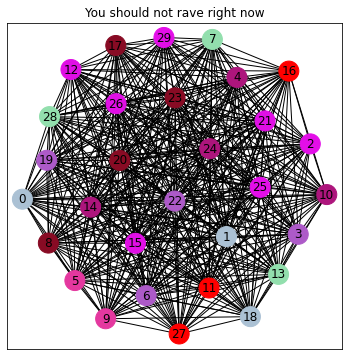

infected people are red


In [165]:
plot_colorized_groups(G, groups, infected)
print('infected people are red')

# Plot & Compare the Virus Effect

In [257]:
def plot(viz, ax, group_status):
    pres = viz.iteration_series(90)
    # I dont think this needs to be the title of every plot since it doesnt change, we can copy this 
    # somewhere else if we need to display it as part of our results
    """infos = viz.model.get_info() 
    descr = ""
    for k, v in future.utils.iteritems(infos):
        descr += "%s: %s, " % (k, v)
    descr = descr[:-2].replace("_", " ")"""
    mx = 0
    i = 0
    for k, l in future.utils.iteritems(pres):
        mx = len(l[0])
        if viz.normalized:
            ax.plot(range(0, mx), l[1]/viz.nnodes, lw=2, label=viz.srev[k], alpha=0.5, color=cols[i])
            ax.fill_between(range(0,  mx), l[0]/viz.nnodes, l[2]/viz.nnodes, alpha=0.2, # had to change alpha to a float
                             color=cols[i])
        else:
            ax.plot(range(0, mx), l[1], lw=2, label=viz.srev[k], alpha=0.5, color=cols[i])
            ax.fill_between(range(0, mx), l[0], l[2], alpha=0.2, # had to change alpha to a float
                             color=cols[i])
        i += 1
    ax.grid(axis="y")
    ax.set_title(group_status)
    ax.set_xlabel("Iterations", fontsize=24)
    ax.set_ylabel(viz.ylabel, fontsize=24)
    ax.legend(loc="best", fontsize=18)
    ax.set_xlim((0, mx))

def plot_comparison(G, infected, r_infect=0.001, r_recover=0.01, iterations = 1000, group_sizes = [4,8,16], weighted = False):    
    original_model, original_trends, _ = sim_virus(G, infected_nodes = infected, iteration = iterations, 
                                                   r_infect = r_infect, r_recover=r_recover)
    original_viz = DiffusionTrend(original_model, original_trends)
    for l in group_sizes:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
        groups = binary_split(G, infected_nodes = infected, limit = l, weighted = weighted)
        model, trends = sim_virus_group(G, groups, original_model, r_infect = r_infect, r_recover = r_recover,
                                        original_infected_nodes = infected, iteration = iterations)
        viz = DiffusionTrend(model, trends)
        plot(viz, ax[0], "Quarantined groups of size >= {}".format(l) )
        plot(original_viz, ax[1], 'No Quarantine')

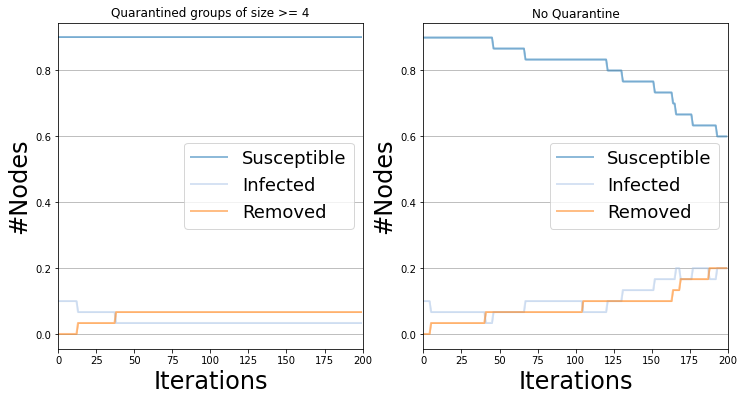

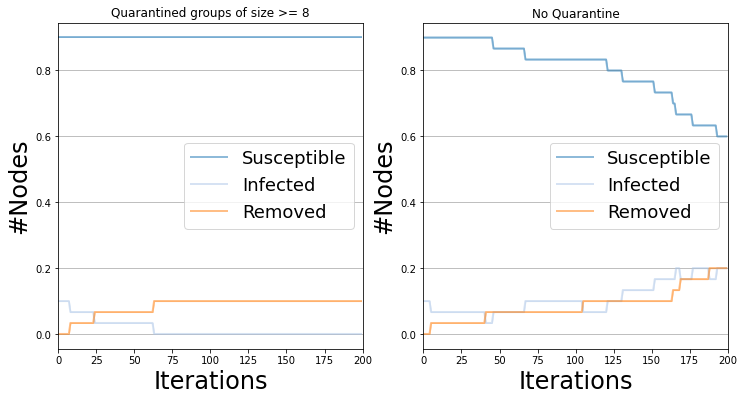

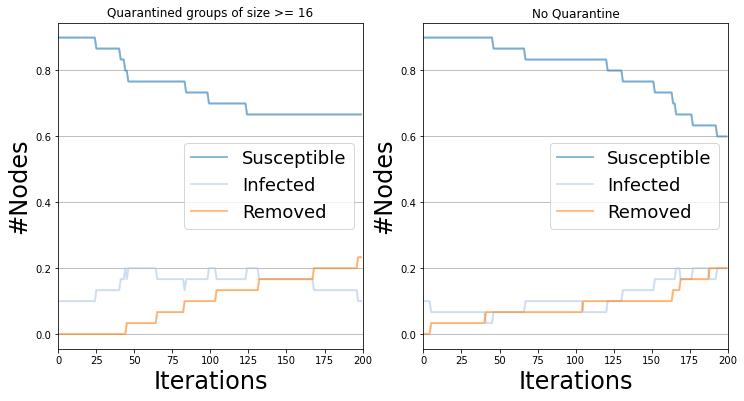

In [220]:
#try for our complete graph on 30 nodes
plot_comparison(G, infected, iterations = 600)

Observations:

We would need to actually look more into the trends, but I'm guessing that whats happening here is that in the grouped into >=4 case, we have around 7 or 8 groups, and in some of them the growth blows up too fast, infecting the whole group, while in others, the growth dies off. Since the groups are entirely isolated and small, this all happens within the first 50 iterations, and then every one either recovers or remains not sick. This is why the rates become constant, I dont think that it's a bug. Ideally, if everyone was individually quarantined the rates would be constant the whole time, because at point of quarantine either you have it or you dont, so it wouldnt change, which is what we expect/want actually.

## Questions
1) Can you find more reasonable graph? 

We need something more like a "community network", where each node is likely interacting with members of its communicaty and less likely outside. Some sources on network theory/covid 19 include.

https://www.nytimes.com/interactive/2020/03/22/world/coronavirus-spread.html: "With each patient infecting two or three others on average, even a perfect response may not have contained the spread." 

http://alumni.media.mit.edu/~tanzeem/Thesis/choudhury_phd_thesis.pdf p57:  These sensors can detect when people are facing each other within a range of approximately six feet

http://snap.stanford.edu/agm/s: Can you generate a community network using this software?

networkx.generators.community has some community network generators, check out left tab in
https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.community.random_partition_graph.html

As a next step we should try to figure out how to make one node possibly part of more than one community, since a person can be part of 1) school 2)family 3)friend group 4)sport team etc...

2) Can you make the cut dependent on the infected people rather than blindly separating?

weight every edge connecting an infected person to a non-infected and non-recovered person by (constant/#nodes) so that the edge is likely to be cut NOTE: This assumes everybody is tested with accuracy and is knowledgeble of their evolving condition in real time, this is not the case in the US but seems to be in some countries like South Korea, Iceland

3) Can you visualize the split better? 

created 'plot_colorized_groups' - colors each group differently and colors the infected people red. PROBLEM: messy and doesnt give an easy to visualize spacial separation

haven't implemented 'plot_spacially_isolated_groups' - A package called grave should be able to help create custom layouts of graphs, so we can probably place each group differently in space so we can easily visualize the groupings/efficacy of the cut

### Answering Q1: Use community networks

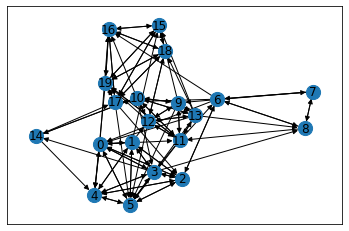

In [125]:
# use networkx.generators.community package. Will use Comm short for community
# arguments are, in order, #nodes, avg #comm, avg #comm/variance, p_connecting edge within comm, p_connecting edge out of comm. 
comm1_n = 20
comm1_s, comm1_v, comm1_p_in, comm1p_out = comm1_n/5, np.sqrt(comm1_n), 1, .02
comm1 = community.gaussian_random_partition_graph(comm1_n, comm1_s, comm1_v, comm1_p_in, comm1p_out)
comm1_init_infect = 0.1
comm1_infected = np.random.choice(range(comm1_n), int(comm1_n*comm1_init_infect), replace=False)
pos = nx.spring_layout(comm1)
nx.draw_networkx(comm1, node_size = 200, alpha = 1)

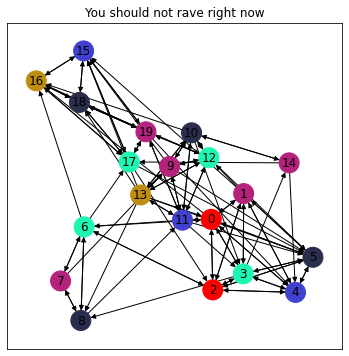

In [174]:
#test it out
comm1_groups = binary_split(comm1,  infected_nodes = comm1_infected, limit = 4, graph= False)
plot_colorized_groups(comm1, comm1_groups, comm1_infected)

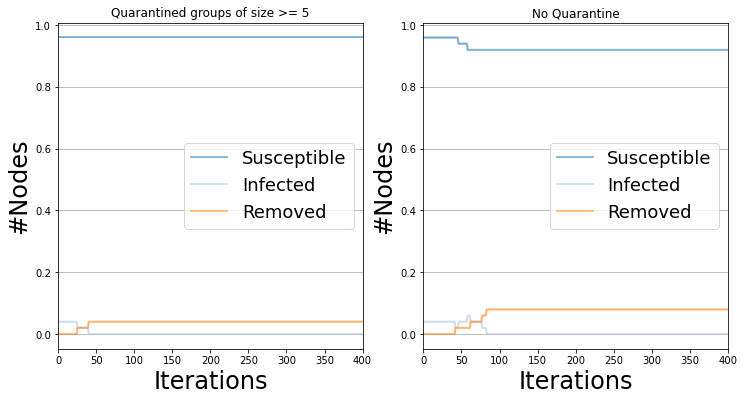

In [227]:
plot_comparison(comm1, comm1_infected, iterations = 400, group_sizes = [5])

### Notes

I feel like this may have been too easy of a case, lets try higher connectivity and higher infection rate. We want the unquarantined case to have exponential infections to mimic the real world, we should probably try upping the node number to at lease 50 as well. We can let one iteration be 1 day. 

For COVID 19 Some stats are: Basic reproductive number around 2.5: https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article

This means the number of susceptible people expected to get infected by 1 infected covid patient.

Patients are infected for 2-14 days https://www.worldometers.info/coronavirus/coronavirus-incubation-period/

Lets say infections last 10 days. Then over 10 days, 2.5 people in contact with them get infected, so the infection rate is 1/4 * 1/10 = .025? This is greater than our models at .001 so far, lets try r_infect = .025.

Then if it takes 10 days to be removed - either by recovery or death, we expect r_recover to be a probability that yields a geometric distribution with a mean of 10. Expected value is 1/p for geom distribution so p = 1/10 = .1, we previously used .01. So we increase both rates, lets see what happens.


Other interesting source - We could potentially increase weight of intercommunity edges to represent a higher secondary infection rate (SAR) as seen here: https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)30462-1/fulltext

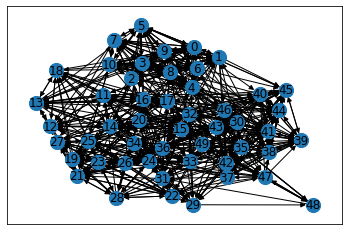

In [200]:
comm2_n = 50
comm2_s, comm2_v, comm2_p_in, comm2_p_out = comm2_n/5, np.sqrt(comm2_n), 1, .15
comm2 = community.gaussian_random_partition_graph(comm2_n, comm2_s, comm2_v, comm2_p_in, comm2_p_out)
comm2_init_infect = 0.1
comm2_infected = np.random.choice(range(comm2_n), int(comm2_n*comm2_init_infect), replace=False)
pos = nx.spring_layout(comm2)
nx.draw_networkx(comm2, node_size = 200, alpha = 1)

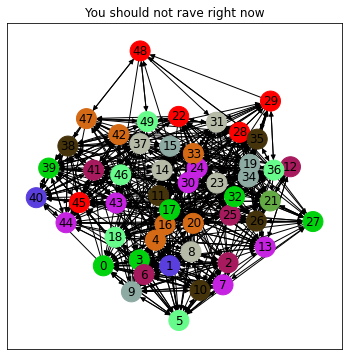

In [201]:
comm2_groups = binary_split(comm2,  infected_nodes = comm2_infected, limit = 6, graph= False)
plot_colorized_groups(comm2, comm2_groups, comm2_infected)

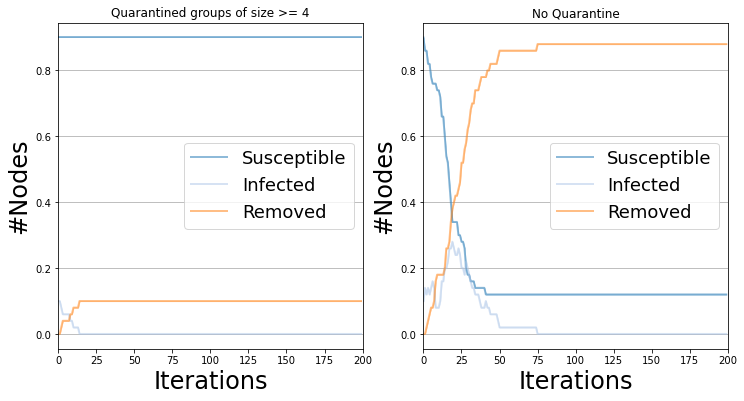

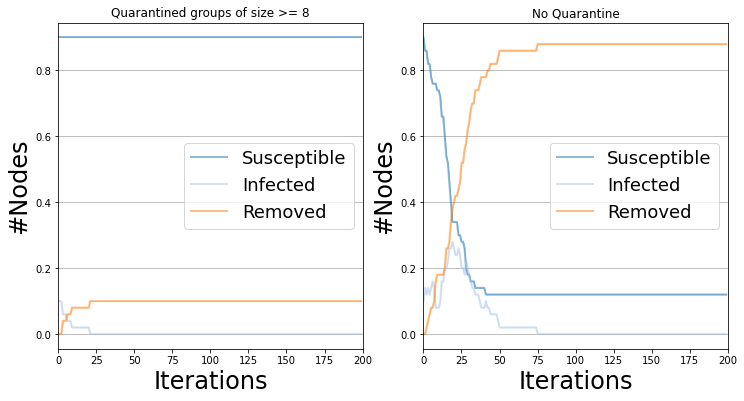

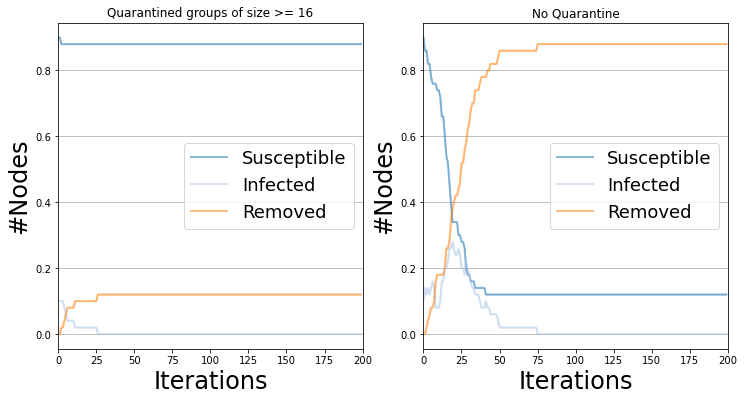

In [221]:
plot_comparison(comm2, comm2_infected, r_infect = .025, r_recover = .1, iterations = 200)

This still is not exponential growth in the non-quarantine case. This could mean that either a) the infection rate is too low, b) the recovery rate is too high, c) there's a bug in our code, d) the graph is not connected enough to represent meaningful potential virus-spreading contact

First lets try the first two

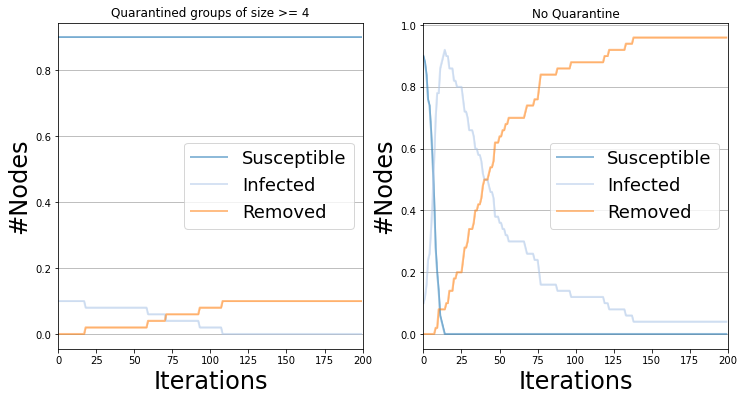

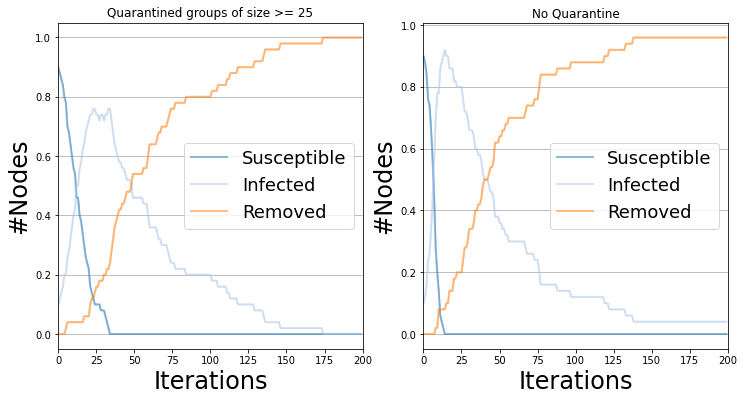

In [229]:
plot_comparison(comm2, comm2_infected, r_infect = .04, r_recover = .02, iterations = 200, group_sizes = [4, 25])

So it looks like blindly splitting the population into very small groups helps a little, and into half does a work to "flatten the curve" a lot in groups of 4 and by 10 percent in groups of 6.

### Question 2

We still need to come up with the correct numbers for r_infect and r_recover, the ones I chose I believe are within an order of magnitude of the correct ones, but that is not really good enough for what we want, though some error could be from our graphs as well. Another point is that .1 of the population is probably not infected when we start the simulaton, in california the lockdown occured on May 20th 2020 when only 40k out of 30m total people were confirmed infected. It would be hard to model such a low initial rate when we only have 50 nodes because we need at least one person to have infection for a simulation to make sense

In [264]:
# Convert an unweighted graph to a weighted graph where edges connecting a non-infected to infected node weighted more
def convert_to_weighted(G, infected):
    G_weighted = nx.Graph()
    G_edges = G.edges
    G_n = len(G_edges)
    for edge in G_edges:
        u, v = edge
        if (u in infected and v not in infected) or (v in infected and u not in infected):
            G_weighted.add_edge(u,v, weight = G_n)
        else:
            G_weighted.add_edge(u,v, weight = 1)
    return G_weighted
            
# Create QUBO dict for D-Wave to optimize
def weighted_maxcut_qubo(G):
    # The Hamiltonian is H = sum(Pauli_Z(i) x Pauli_Z(j) - I)/2
    # The eigenvalue is the negation of the edges in cut solution
    # The QUBO should be -xi-xj+2xixj, we label it as Q
    Q = defaultdict(int)
    for u, v in G.edges:
        w = G.get_edge_data(u,v)['weight']
        Q[(u,u)]+= -w
        Q[(v,v)]+= -w
        Q[(u,v)]+= 2*w
    return Q

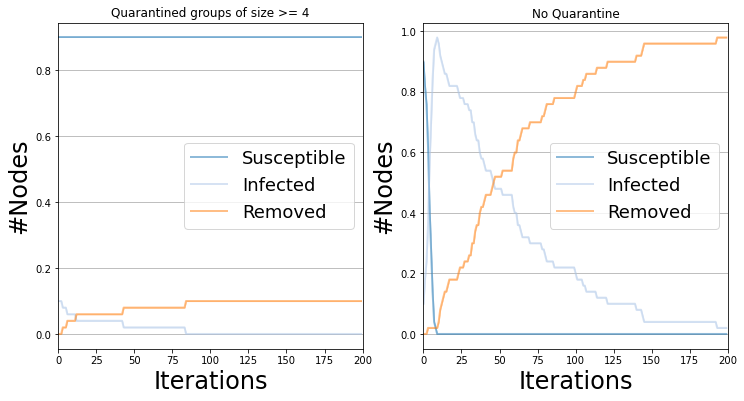

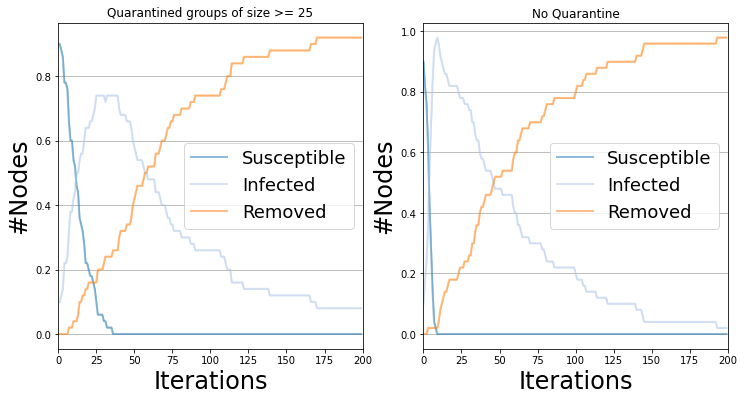

In [269]:
comm2_weighted = convert_to_weighted(comm2, comm2_infected)
plot_comparison(comm2_weighted, comm2_infected, r_infect = .04, r_recover = .02, iterations = 200, group_sizes = [4, 25])

Compare this to the plot for comm2 in the unweighted case, we are able to flatten the curve in the group of 16 case by around 10 percent. In the weighted case we flattened the curve a bit more, but this remains to be tested more and played with